# Grupo 1
- Rodolfo Freire (rfpf2@cesar.school)

- Rosinaldo Guedes (rglj@cesar.school)

- Wolney Leite (wlm@cesar.school)


Dataset escolhido: Neural Networks Homer and Bart Classification (https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification)

# Importação das dependências

In [21]:
# Bibliotecas padrão do Python
import os
import glob
import random
import optparse

# Bibliotecas de terceiros
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import seaborn as sns

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# Scikit-image
from skimage.feature import hog

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms


# Parâmetros de execução

In [22]:
# Fixar sementes para reprodutibilidade
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Uso da CPU ou GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [23]:
# Configurações de parâmetros
IMG_SIZE      = 64
N_COMPONENTES = 70     # nº de componentes do PCA
BATCH_SIZE    = 32
LR            = 0.0005
NUM_EPOCHS    = 80
WEIGHT_DECAY  = 0.0001
PATIENCE      = 10

# Carregamento do Dataset

In [24]:
# Download das imagens via KaggleHub
path = kagglehub.dataset_download("juniorbueno/neural-networks-homer-and-bart-classification")
print("Path to dataset files:", path)

# Separação das imagens
all_images = []
homer_images = []
bart_images = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.lower().endswith((".bmp")):
            image_path = os.path.join(dirname, filename)
            all_images.append(image_path)

            fname = filename.lower()
            if 'homer' in fname:
                homer_images.append(image_path)
            elif 'bart' in fname:
                bart_images.append(image_path)
            else:
                print("Arquivo com nome inesperado (não contém 'homer' nem 'bart'):", image_path)

print(f"Quantidade total de imagens: {len(all_images)}")
print(f"Quantidade de imagens do Homer: {len(homer_images)}")
print(f"Quantidade de imagens do Bart: {len(bart_images)}")

Using Colab cache for faster access to the 'neural-networks-homer-and-bart-classification' dataset.
Path to dataset files: /kaggle/input/neural-networks-homer-and-bart-classification
Quantidade total de imagens: 269
Quantidade de imagens do Homer: 109
Quantidade de imagens do Bart: 160


# Gerar novas imagens (feature engineering)

In [25]:
def augment_image(img):
    """Aplica 1 transformação aleatória."""
    choice = random.choice(["flip", "rotate", "brightness", "noise", "blur"])

    if choice == "flip":
        return img.transpose(Image.FLIP_LEFT_RIGHT)

    elif choice == "rotate":
        angle = random.uniform(-10, 10)
        return img.rotate(angle)

    elif choice == "brightness":
        factor = random.uniform(0.7, 1.3)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)

    elif choice == "noise":
        arr = np.array(img)
        noise = np.random.normal(0, 10, arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

    elif choice == "blur":
        return img.filter(ImageFilter.GaussianBlur(radius=1))

def generate_only_n_augmented_images_in_memory(image_paths, n_copies):
    """
    Gera um número exato de 'n_copies' imagens aumentadas a partir de caminhos de arquivo.
    """
    augmented_images = []

    for i in range(n_copies):
        img_path = random.choice(image_paths)
        img = Image.open(img_path)
        aug = augment_image(img)
        augmented_images.append(aug.copy())

    return augmented_images

# Calcular quantas imagens precisam ser geradas
N_TARGET = 160
N_HOMER_ORIGINAL = 109
N_COPIES_TO_GENERATE = N_TARGET - N_HOMER_ORIGINAL

# Gerar as novas imagens
augmented_homers_imgs = generate_only_n_augmented_images_in_memory(
    homer_images,
    n_copies=N_COPIES_TO_GENERATE
)

print(f"Novas imagens geradas: {len(augmented_homers_imgs)}")

# Carregar as 109 imagens originais
# Transforma a lista de caminhos em uma lista de objetos de imagem
original_homers_imgs = [Image.open(path) for path in homer_images]

# Concatenar as listas para formar o total de 160 imagens
homer_images = original_homers_imgs + augmented_homers_imgs

Novas imagens geradas: 51


In [26]:
print(f"Quantidade de imagens do Homer: {len(homer_images)}")
print(f"Quantidade de imagens do Bart: {len(bart_images)}")

Quantidade de imagens do Homer: 160
Quantidade de imagens do Bart: 160


# Extração de Características HOG e Preparação do Dataset

In [27]:
def extract_hog(path, img_size=(IMG_SIZE, IMG_SIZE)):
    img = Image.open(path).convert("L")
    img = img.resize(img_size)
    img_arr = np.array(img, dtype=np.float32) / 255.0

    features = hog(
        img_arr,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

    return features.astype(np.float32)

In [28]:
def extract_hog_from_pil(img, img_size=(IMG_SIZE, IMG_SIZE)):
    img = img.convert("L")
    img = img.resize(img_size)
    img_arr = np.array(img, dtype=np.float32) / 255.0

    features = hog(
        img_arr,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )
    return features.astype(np.float32)

In [29]:
X_list = []
y_list = []

# 0 = Bart, 1 = Homer
for p in bart_images:
    X_list.append(extract_hog(p))
    y_list.append(0)

for p in homer_images:
    X_list.append(extract_hog_from_pil(p))
    y_list.append(1)

X = np.stack(X_list, axis=0)
y = np.array(y_list, dtype=np.float32)

print("Shape X (HOG):", X.shape)   # [N_amostras, N_features]
print("Shape y:", y.shape)


Shape X (HOG): (320, 1764)
Shape y: (320,)


# Separação de Dados (Treino/Validação)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)

Treino: (256, 1764) (256,)
Validação: (64, 1764) (64,)


# Normalização (StandardScaler) e Redução de Dimensionalidade (PCA)

In [31]:
# 1) padroniza features (média 0, desvio 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 2) PCA
pca = PCA(n_components=N_COMPONENTES, whiten=True, random_state=seed)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)

print("Train PCA:", X_train_pca.shape)
print("Val PCA:", X_val_pca.shape)


Train PCA: (256, 70)
Val PCA: (64, 70)


# Criação de DataLoaders PyTorch

In [32]:
# converte para tensores
X_train_t = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_t = torch.tensor(y_train,     dtype=torch.float32)

X_val_t = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_t = torch.tensor(y_val,     dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

# Definição do Modelo MLP (HOGMLP)

In [33]:
input_dim = X_train_t.shape[1]   # nº de features HOG

class HOGMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 1)  # logit
        )

    def forward(self, x):
        return self.net(x)

model = HOGMLP(input_dim).to(device)
print(model)

HOGMLP(
  (net): Sequential(
    (0): Linear(in_features=70, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Configuração do Treinamento (Loss, Otimizador e Scheduler)

In [34]:
# Penalização da classe minoritária (Homer)
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
pos_weight = torch.tensor(weights[1] / weights[0]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

# Funções Auxiliares de Treinamento e Avaliação

In [35]:
def binary_accuracy(logits, labels):
    probs = torch.sigmoid(logits).view(-1)
    preds = (probs >= 0.5).float()
    correct = (preds == labels).float().sum()
    return correct / labels.size(0)

def run_epoch(loader, model, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    epoch_acc  = 0.0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).view(-1, 1)

        if optimizer is not None:
            optimizer.zero_grad()

        logits = model(x)
        loss   = criterion(logits, y)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        bs  = x.size(0)
        acc = binary_accuracy(logits.detach(), y.view(-1))

        epoch_loss += loss.item() * bs
        epoch_acc  += acc.item()  * bs
        total      += bs

    return epoch_loss / total, epoch_acc / total

# Loop de Treinamento e Early Stopping

In [36]:
# listas para gráficos
history_train_loss, history_val_loss = [], []
history_train_acc,  history_val_acc  = [], []

best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss,   val_acc   = run_epoch(val_loader,   model, criterion, optimizer=None)

    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_acc)
    history_val_acc.append(val_acc)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"[Scheduler] LR: {old_lr:.6f} -> {new_lr:.6f}")

    print(f"[{epoch:03d}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss   = val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("Early stopping acionado!")
        break

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)


[001/80] Train Loss: 0.7058 | Train Acc: 0.4961 | Val Loss: 0.6964 | Val Acc: 0.4844
[002/80] Train Loss: 0.6970 | Train Acc: 0.5234 | Val Loss: 0.6974 | Val Acc: 0.5000
[003/80] Train Loss: 0.6844 | Train Acc: 0.5469 | Val Loss: 0.6958 | Val Acc: 0.4844
[004/80] Train Loss: 0.6835 | Train Acc: 0.5508 | Val Loss: 0.6924 | Val Acc: 0.5469
[005/80] Train Loss: 0.6517 | Train Acc: 0.6172 | Val Loss: 0.6907 | Val Acc: 0.5156
[006/80] Train Loss: 0.6469 | Train Acc: 0.6523 | Val Loss: 0.6849 | Val Acc: 0.5938
[007/80] Train Loss: 0.6411 | Train Acc: 0.6484 | Val Loss: 0.6788 | Val Acc: 0.6250
[008/80] Train Loss: 0.6355 | Train Acc: 0.6445 | Val Loss: 0.6722 | Val Acc: 0.6406
[009/80] Train Loss: 0.6060 | Train Acc: 0.7383 | Val Loss: 0.6677 | Val Acc: 0.6406
[010/80] Train Loss: 0.5895 | Train Acc: 0.7148 | Val Loss: 0.6620 | Val Acc: 0.6719
[011/80] Train Loss: 0.6056 | Train Acc: 0.7305 | Val Loss: 0.6558 | Val Acc: 0.6875
[012/80] Train Loss: 0.5608 | Train Acc: 0.7891 | Val Loss: 0.649

# Visualização dos Resultados (Loss e Acurácia)

In [37]:
# Avaliação final na validação

model.eval()
val_loss, val_acc = run_epoch(val_loader, model, criterion, optimizer=None)
print(f"\nDesempenho final na validação: "
      f"Loss = {val_loss:.4f} | Acc = {val_acc:.4f}")


Desempenho final na validação: Loss = 0.3519 | Acc = 0.8438


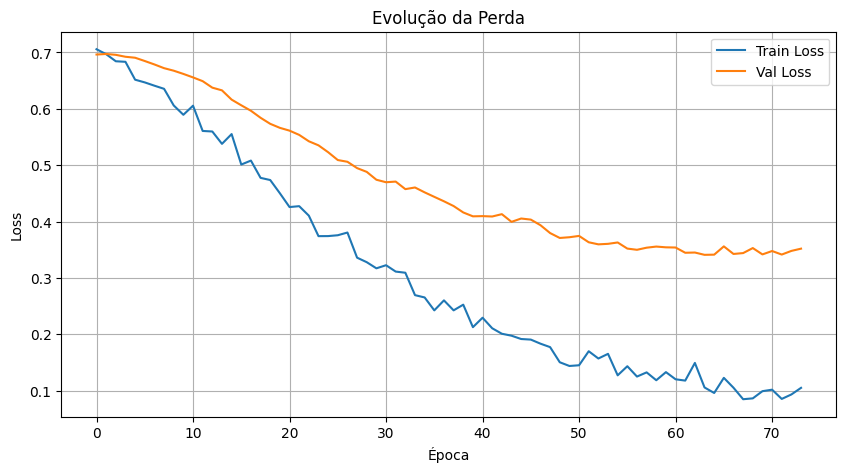

In [38]:
# Gráfico da perda
plt.figure(figsize=(10, 5))
plt.plot(history_train_loss, label='Train Loss')
plt.plot(history_val_loss, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da Perda')
plt.legend()
plt.grid(True)
plt.show()


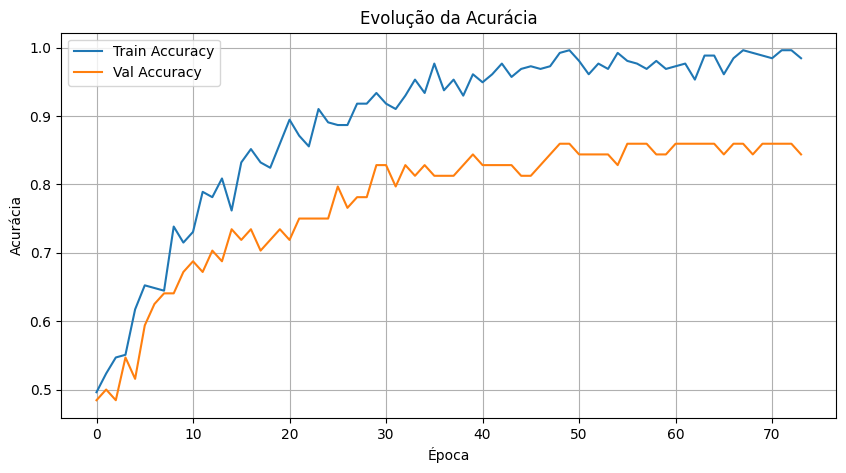

In [39]:
# Gráfico da acurácia
plt.figure(figsize=(10, 5))
plt.plot(history_train_acc, label='Train Accuracy')
plt.plot(history_val_acc, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# Análise de Desempenho (Matriz de Confusão)

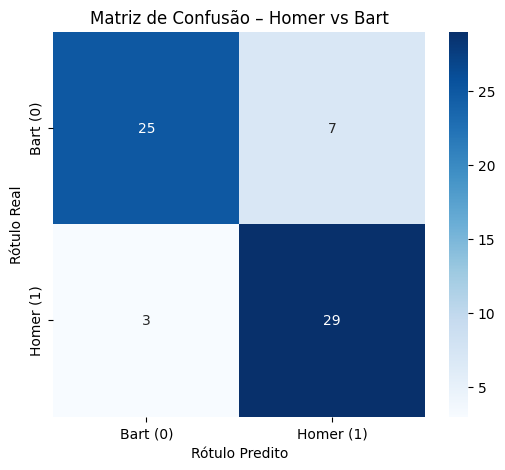

In [40]:
# colocar o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        probs = torch.sigmoid(logits).view(-1)

        preds = (probs >= 0.5).float()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bart (0)', 'Homer (1)'],
            yticklabels=['Bart (0)', 'Homer (1)'])
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')
plt.title('Matriz de Confusão – Homer vs Bart')
plt.show()

# Conclusões

Classificar as imagens dos personagens Homer e Bart Simpson utilizando Redes Neurais Artificiais, sob a restrição explícita de não empregar camadas convolucionais, obrigou a adoção de abordagens alternativas de extração de características, uma vez que redes MLP puras não são adequadas para manipular imagens brutas devido à perda completa da estrutura espacial quando os dados são achatados (flatten).

Inicialmente, a estratégia adotada foi a mais direta: carregar as imagens, convertê-las para tons de cinza, reduzi-las para dimensões menores e utilizá-las como vetores de entrada para uma rede MLP densa. A primeira arquitetura definida foi relativamente simples, com camadas densas de grande porte (1024-512-256-64-1), ativação ReLU nas camadas ocultas e Sigmoid na saída. O objetivo era observar se, com uma redução agressiva das imagens, o MLP seria capaz de encontrar padrões globais suficientes para separar as classes.

Entretanto, os primeiros resultados mostraram overfitting extremo: a rede atingia quase 100% de acurácia no treinamento, mas permanecia próxima de 50% na validação. Isso indicava que o MLP estava simplesmente decorando os dados, mas incapaz de generalizar.

Para mitigar o overfitting, aplicamos melhorias graduais: redução de tamanho das imagens (64x64 -> 32x32), aumento do dropout, diminuição da capacidade da rede, normalização das imagens e data augmentation (rotações suaves, flips horizontais, variação de brilho/contraste). Com essas alterações, o modelo passou a se comportar melhor, mas ainda assim as acurácias de validação continuavam em torno de 50%–55%, revelando que o MLP não conseguia extrair as características relevantes diretamente dos pixels.

Diante disso, evoluímos para uma abordagem mais robusta: aplicar redução de dimensionalidade via PCA (Principal Component Analysis) antes de alimentar o MLP, mantendo as dimensões em 64x64 das imagens. A primeira tentativa com 50 componentes melhorou os resultados, mas não o suficiente. Ajustamos para 70 componentes, e pela primeira vez o modelo apresentou um comportamento consistente: a acurácia de treinamento cresceu gradualmente e a de validação estabilizou entre 68% e 72%, com loss decrescente e sem overfitting significativo. Foi a primeira evidência concreta de que estávamos próximos de uma solução funcional e coerente com as limitações impostas.

Após esse resultado, exploramos a utilização de HOG (Histogram of Oriented Gradients). O HOG é um método clássico de visão computacional que extrai características estruturais baseadas em gradientes e bordas, preservando informações de forma, contorno e orientação, ideais para diferenciar personagens como Homer e Bart, cujos contornos, cabelos e proporções faciais são bastante distintos. Com HOG, construímos novamente um pipeline composto por: leitura da imagem, extração do vetor HOG, normalização e treinamento de um MLP compacto.

Também procuramos resolver o problema de desbalanceamento entre classes, já que havia mais imagens do Bart do que de Homer. Para contornar isso sem excluir dados, foram utilizadas as seguintes técnicas:

- Uso de class_weight no BCEWithLogitsLoss;
- Data augmentation direcionada para a classe minoritária;

O resultado final é um pipeline coerente com as restrições do problema, atingindo boa performance mesmo sem Redes Convolucionais.